In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plot
import scipy
from sklearn.metrics import mean_squared_error
import gc

## **1. Data preparation**






### A. Global predictor

In [ ]:
predictor = pd.read_feather("pw")**2

In [ ]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler().fit(predictor)
predictor = fit.transform(predictor)

In [ ]:
lonlat = pd.read_feather("lonlat")
lat, lon = lonlat['lat'], lonlat['lon']
x, y = np.unique(lon), np.unique(lat)
X, Y = np.meshgrid(x, y)
coords = np.vstack((X.flatten(), Y.flatten()))
i = np.zeros(lat.size)
for k in range(i.size):
    i[k] = np.where((coords[0]==lon[k]) & (coords[1]==lat[k]))[0]
i = i.astype(int)
pw = np.zeros((predictor.shape[0], x.size * y.size)) * np.nan
pw[:, i] = predictor 
pw = pw.reshape((predictor.shape[0], y.size, x.size))
pw[np.isnan(pw)] = 0
del predictor

### B. Local predictor



In [ ]:
import math 
homere = pd.read_feather("/content/drive/My Drive/data/homere")
f = np.array(homere['fetch']).reshape((homere.shape[0],1))
w = np.sqrt(np.array(homere["uwnd"]**2)+np.array(homere["vwnd"]**2)).reshape((homere.shape[0],1))
local = np.concatenate((w,w**2,w**3,f*w**2), axis = 1)

### C. Predictand ($H_s$)

In [ ]:
h = homere['hs']

## **2. Two-stage model**

In [ ]:
def first_stage(input_shape, output_shape):

    x = keras.layers.Input(input_shape)

    l = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation = "relu",padding='valid')(x) 
    l = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(l)
    l = keras.layers.BatchNormalization(axis = -1)(l)
    l = keras.layers.Dropout(0.3)(l)
     
    l = keras.layers.ZeroPadding2D((2,1))(l)
    l = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation = "relu",padding='valid')(l)
    l = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(l)
    l = keras.layers.BatchNormalization(axis = -1)(l)
    l = keras.layers.Dropout(0.2)(l)

    l = keras.layers.ZeroPadding2D((2,1))(l)    
    l = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation = "relu",padding='valid')(l)
    l = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(l)
    l = keras.layers.BatchNormalization(axis = -1)(l)
    l = keras.layers.Dropout(0.2)(l)
    
    l = keras.layers.ZeroPadding2D((2,1))(l)
    l = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation = "relu",padding='valid')(l)
    l = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(l)
    l = keras.layers.BatchNormalization(axis = -1)(l)
    l = keras.layers.Dropout(0.3)(l)

    l = keras.layers.ZeroPadding2D((2,1))(l)
    l = keras.layers.Conv2D(filters=64, kernel_size=(3, 3),  activation = "relu",padding='valid')(l)
    l = keras.layers.BatchNormalization(axis = -1)(l)
    l = keras.layers.Flatten()(l) 
    l = keras.layers.Dropout(0.5)(l)

    outputs = keras.layers.Dense(output_shape)(l)

    model = keras.models.Model(inputs = x, outputs = outputs)
    return model
def second_stage(input_shape):
    
    x1 = keras.layers.Input(input_shape[0])
    x2 = keras.layers.Input(input_shape[1])
    
    l1 = keras.layers.LSTM(120)(x1)
    l1 = keras.layers.Flatten()(l1)
    l1 = keras.layers.Dropout(0.3)(l1)

    l2 = keras.layers.Concatenate()([l1, x2])
    l2 = keras.layers.Dense(50, activation = "relu")(l2)
    l2 = keras.layers.Dense(50, activation = "relu")(l2)
    l2 = keras.layers.Dropout(0.2)(l2)
    
    outputs = keras.layers.Dense(1, activation = "linear")(l2)

    model = keras.models.Model(inputs = [x1,x2], outputs = outputs)
    return model

In [ ]:
loss_fn = keras.losses.mse
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
gc.collect()

64

### A. Cross-validation


In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=None, shuffle=False)

In [ ]:
for train_index, test_index in cv.split(pw):
  print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [13442 13443 13444 ... 67205 67206 67207] TEST: [    0     1     2 ... 13439 13440 13441]
TRAIN: [    0     1     2 ... 67205 67206 67207] TEST: [13442 13443 13444 ... 26881 26882 26883]
TRAIN: [    0     1     2 ... 67205 67206 67207] TEST: [26884 26885 26886 ... 40323 40324 40325]
TRAIN: [    0     1     2 ... 67205 67206 67207] TEST: [40326 40327 40328 ... 53764 53765 53766]
TRAIN: [    0     1     2 ... 53764 53765 53766] TEST: [53767 53768 53769 ... 67205 67206 67207]


In [ ]:
means = np.zeros(np.array(range(5, 55, 5)).shape)
mins = np.zeros(np.array(range(5, 55, 5)).shape)
maxs = np.zeros(np.array(range(5, 55, 5)).shape)
i = 0
for tmax in range(5, 55, 5):
  ind = np.arange(0,(h.shape[0]-tmax))
  hs = np.transpose(np.array(list(map(lambda t: h[ind+t], np.arange(0,tmax)))))
  w = pw[ind]
  lo = local[ind]
  x = w[0:58340,:,:]
  y = hs[0:58340,]
  l = lo[0:58340]
  x = x.reshape((x.shape[0], x.shape[1],x.shape[2],1))
  folds = cv.split(x)
  rmse = []
  del w
  del lo
  for train_index, test_index in folds:
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    l_train, l_test = l[train_index], l[test_index]
    model1 = first_stage(x_train.shape[1:], y_train.shape[1])
    model1.compile(optimizer=optimizer, loss=loss_fn)
    model1.fit(x_train, y_train, epochs=10, batch_size=64)
    pred_train = model1.predict(x_train)
    pred_test  = model1.predict(x_test)
    del x_train
    del x_test
    del model1 
    gc.collect()
    p_train = np.array(list(map(lambda t: pred_train[(t-tmax):t], np.arange(tmax,pred_train.shape[0]))))
    p_test = np.array(list(map(lambda t: pred_test[(t-tmax):t], np.arange(tmax,pred_test.shape[0]))))
    p_train = p_train.reshape((p_train.shape[0],p_train.shape[1],p_train.shape[2]))
    p_test = p_test.reshape((p_test.shape[0],p_test.shape[1],p_test.shape[2]))
    ll_train = np.concatenate((l_train[tmax:(l_train.shape[0]),:], l_train[(tmax-1):(l_train.shape[0]-1),:]), axis = 1)
    ll_test = np.concatenate((l_test[tmax:(l_test.shape[0]),:], l_test[(tmax-1):(l_test.shape[0]-1),:]), axis = 1)
    fit = StandardScaler().fit(ll_train)
    ll_train = fit.transform(ll_train)
    ll_test = fit.transform(ll_test)
    yy_train = y_train[tmax:(y_train.shape[0]),0]
    yy_test = y_test[tmax:(y_test.shape[0]),0]
    del pred_train
    del pred_test  
    model2 = second_stage([p_train.shape[1:],ll_train.shape[1:]])
    model2.compile(optimizer=optimizer, loss=loss_fn,)
    model2.fit([p_train,ll_train], yy_train, epochs=50, verbose=2, batch_size=64)
    pred = model2.predict([p_test,ll_test])
    del model2
    keras.backend.clear_session()
    rm = mean_squared_error(yy_test,pred)**(1/2)
    rmse.append(rm)
  rmse = np.array(rmse)  
  means[i] = np.mean(rmse)     
  mins[i] = np.min(rmse)
  maxs[i] = np.max(rmse)
  np.save("meanss", means)
  np.save("minss", mins)
  np.save("maxss", maxs)
  i = i+1

In [ ]:
means = np.load("meanss.npy")
mins = np.load("minss.npy")
maxs = np.load("maxss.npy")

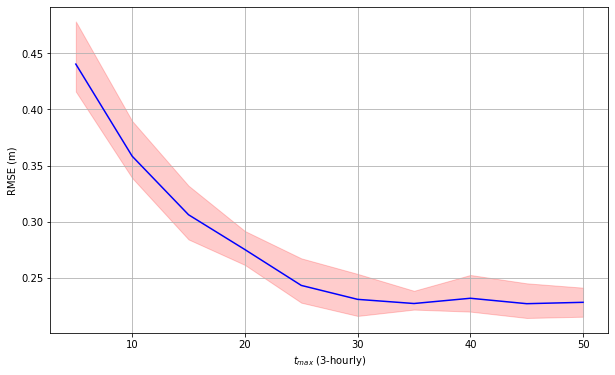

In [ ]:
plot.rcParams['figure.figsize'] = [10, 6]
fig, ax = plot.subplots()
ax.plot(np.arange(5,55,5), means, color = 'b')
ax.fill_between(np.arange(5,55,5), (mins), (maxs), color='r', alpha=.2)
plot.xlabel("$t_{max}$ (3-hourly)")
plot.ylabel("RMSE (m)")
plot.grid()

### B. Model fitting (with $t_{max} = 30$)

In [ ]:
tmax = 30
ind = np.arange(0,(h.shape[0]-tmax))
time = pd.date_range('1994-01-01', end='2016-12-31 23:00' , freq='3h')
time = time[ind]
hs = np.transpose(np.array(list(map(lambda t: h[ind+t], np.arange(0,tmax)))))
pw = pw[ind]
local = local[ind]
x_train = pw[0:58340,:,:]
x_test = pw[58340:,:,:]
y_train = hs[0:58340,]
y_test = hs[58340:,]
l_train = local[0:58340]
l_test = local[58340:]
time_train = time[0:58340]
time_test = time[58340:]

In [ ]:
del pw
del hs
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],x_test.shape[2],1))

In [ ]:
model1 = first_stage(x_train.shape[1:], y_train.shape[1])
model1.compile(optimizer=optimizer, loss=loss_fn)
model1.fit(x_train, y_train, epochs=10, batch_size=64)

In [ ]:
#model1.save('cnn_model')

In [ ]:
model1 = keras.models.load_model("cnn_model")

In [ ]:
pred_train = model1.predict(x_train)
pred_test  = model1.predict(x_test)

In [ ]:
del x_train
del x_test
del model1 
gc.collect()

41763

In [ ]:
p_train = np.array(list(map(lambda t: pred_train[(t-tmax):t], np.arange(tmax,pred_train.shape[0]))))
p_test = np.array(list(map(lambda t: pred_test[(t-tmax):t], np.arange(tmax,pred_test.shape[0]))))
p_train = p_train.reshape((p_train.shape[0],p_train.shape[1],p_train.shape[2]))
p_test = p_test.reshape((p_test.shape[0],p_test.shape[1],p_test.shape[2]))
ll_train = np.concatenate((l_train[tmax:(l_train.shape[0]),:], l_train[(tmax-1):(l_train.shape[0]-1),:]), axis = 1)
ll_test = np.concatenate((l_test[tmax:(l_test.shape[0]),:], l_test[(tmax-1):(l_test.shape[0]-1),:]), axis = 1)
fit = StandardScaler().fit(ll_train)
ll_train = fit.transform(ll_train)
ll_test = fit.transform(ll_test)
yy_train = y_train[tmax:(y_train.shape[0]),0]
yy_test = y_test[tmax:(y_test.shape[0]),0]

In [ ]:
del pred_train
del pred_test  

In [ ]:
model2 = second_stage([p_train.shape[1:],ll_train.shape[1:]])

In [ ]:
model2.compile(optimizer=optimizer, loss=loss_fn,)
model2.fit([p_train,ll_train], yy_train, epochs=70, verbose=2, batch_size=64)

In [ ]:
#model2.save('lstm_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/lstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/lstm_model/assets


In [ ]:
model2 = keras.models.load_model("lstm_model")

### C. Make predictions

In [ ]:
pred = model2.predict([p_test,ll_test])
fitted = model2.predict([p_train,ll_train])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(yy_test,pred)**(1/2) ,mean_squared_error(yy_train,fitted)**(1/2)

(0.21072657252171315, 0.20309537579485748)

In [ ]:
np.corrcoef(yy_test.reshape(yy_test.shape[0],1).transpose(),pred.transpose())

array([[1.        , 0.98352364],
       [0.98352364, 1.        ]])

In [ ]:
np.corrcoef(yy_train.reshape(yy_train.shape[0],1).transpose(),fitted.transpose())

array([[1.        , 0.98455837],
       [0.98455837, 1.        ]])

In [ ]:
np.mean(yy_test-pred)

-0.0062717155863481625

In [ ]:
np.mean(yy_train.reshape(yy_train.shape[0],1) - fitted)

0.049719117561784924

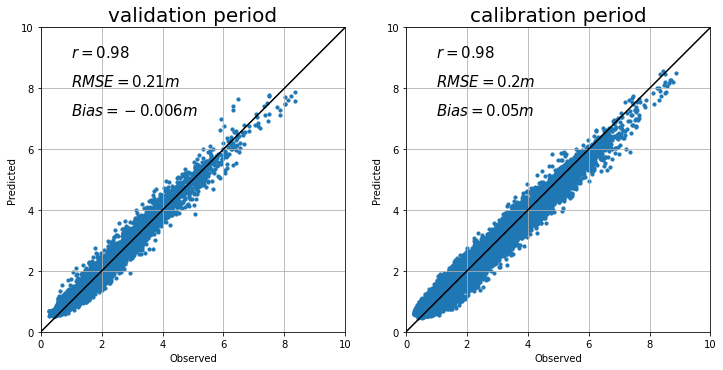

In [ ]:
fig = plot.figure()
ax = fig.add_subplot(121)
plot.rcParams['figure.figsize'] = [12, 12]
plot.scatter(yy_test, pred, s = 10)
plot.plot([0, 10], [0, 10], ls="-", c = "black")
plot.xlim(0, 10)
plot.ylim(0, 10)
plot.text(1,7.1 , "$r = 0.98$\n$RMSE = 0.21 m$\n$Bias = -0.006 m$", size = 15, linespacing=2)
plot.xlabel('Observed')
plot.ylabel('Predicted')
plot.title('validation period', fontsize=20)
plot.grid()
ax.set_aspect('equal', adjustable='box')
#ax = fig.add_subplot(211)
ax = fig.add_subplot(122)
plot.scatter(yy_train, fitted, s = 10)
plot.plot([0,10], [0, 10], ls="-", c = "black")
plot.xlim(0, 10)
plot.ylim(0, 10)
plot.text(1,7.1 , "$r = 0.98$\n$RMSE = 0.2 m$\n$Bias = 0.05 m$", size = 15, linespacing=2)
plot.xlabel('Observed')
plot.ylabel('Predicted')
plot.title('calibration period', fontsize=20)
plot.grid()
ax.set_aspect('equal', adjustable='box')

In [ ]:
time_train = time_train[tmax:(y_train.shape[0])]
time_test = time_test[tmax:(y_test.shape[0])]

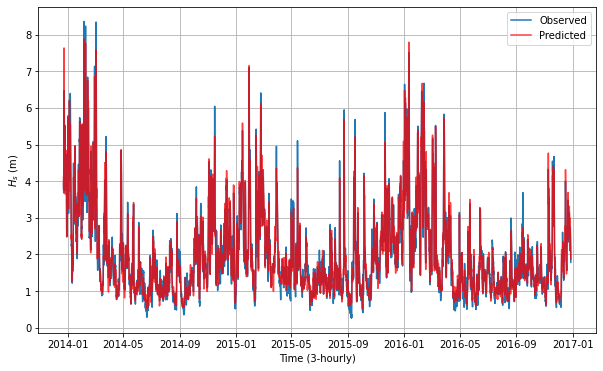

In [ ]:
plot.rcParams['figure.figsize'] = [10, 6]
plot.plot(time_test, yy_test, label='Observed')
plot.plot(time_test, pred, alpha=0.75, label='Predicted',  color="r")
plot.legend()
plot.xlabel('Time (3-hourly)')
plot.ylabel('$H_s$ (m)')
plot.grid()